# Clustering
In many applications, results or intermediate results of modal analysis contain more than one mode for each _physical_ mode. Examples of this are:
 - [Stochastic Subspace Identification (SSI)](ssi.html) yields _two_ identified modes for each physical mode. Also, SSI requires the _model order_ parameter to be specified. If SSI is performed with a variable parameter, the total set of modes (of all concerned model orders) possibly contain a lot more identified modes per physical mode.
 - In a monitoring scenario of a civil structure, datasets are analysed in regular intervals. Operational modal analysis is performed on them individually, yielding a sequence of sets of identified modes.
 - In numerical modal analysis, the prediction of modes with a Finite-Element model may be done for many possible values of input parameters, e.g. in a sensitivity analysis, a monte-carlo simulation or probabilistic system identification, to name a few applications.

All of these have in common, that for further processing, examination, or presentation it is useful to _group_ the _identified_ modes belonging to the same _physical_ mode together. Specialised methods evolved for every usecase, as consecutive filtering of a SSI stabilization diagram or [Modal Tracking](https://www.sciencedirect.com/search?qs=modal%20tracking).

While these methods ideally fit the specific needs, their applications share common structures. One way to address _all_ of these, is to apply [Clustering](https://scikit-learn.org/stable/modules/clustering.html) in order to group the identified modes.


## Principles

### Data Structures
An identified mode inherently contains the three modal properties of modal _frequency_, _damping_, and _shape_. If the mode belongs to a specified _set_ of modes, it also contains an _index_ as identifier to which set it belongs. This index can be a _model order_ in an SSI scenario or a _dataset number_ in a monitoring scenario.

In order to enable consistent and concise interfaces custom datastructures are defined using Python's [NamedTuple](https://docs.python.org/3/library/typing.html#typing.NamedTuple), a typed version of [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple). This bears the cost of transforming a sequence of sets of modes into this datastructure but enables simple and clear application of clustering.

Since the `pyomac` package works internally with `numpy` (as every efficient numerical python tool should), a single set of modes is comprised of three numpy arrays, sequentially holding information about the frequencies, dampings and shapes of the modes.

```
class ModalSet(NamedTuple):
    """Represents a modal set.

    implicit convention:
    frequencies: np.ndarray (n_modes x 1)
    dampings: np.ndarray (n_modes x 1)
    modeshapes: np.ndarray (n_modes x n_dof)
    """

    frequencies: np.ndarray
    dampings: np.ndarray
    modeshapes: np.ndarray
```

As previously stated, every set of modes usually has an index.
```
class IndexedModalSet(NamedTuple):
    """Represents a modal set.

    implicit convention:
    indices: np.ndarray (n_modes x 1)
    frequencies: np.ndarray (n_modes x 1)
    dampings: np.ndarray (n_modes x 1)
    modeshapes: np.ndarray (n_modes x n_dof)
    """

    indices: np.ndarray
    frequencies: np.ndarray
    dampings: np.ndarray
    modeshapes: np.ndarray
```

As we will see later, the choice to store the index of each mode separately in the `indices` array enables this data structure to be used for the results of clustering as well. This way each mode can retain the information of which modal sets it orignated from.

### Hierarchical Clustering

In [Hierarchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) clusters are formed by splitting and merging other clusters. [Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) is the bottom-up approach where clusters are solely merged. To begin with, each data point (which in our case is an identified mode) is interpreted as a cluster containing only this one data point.

The clusters are then merged based on the distance between the clusters (which is defined by a distance metric between their corresponding data points). The distance between two modes $i$ and $j$ is defined as:

$d_{i,j} = \frac{f_i - f_j}{max(f_i, f_j)} + 1 - MAC(\phi_i, \phi_j)$

This is largely based on this reference:

[1]    REYNDERS, E., J. HOUBRECHTS AND G. DE ROECK
    Fully automated (operational) modal analysis.
    Mechanical Systems and Signal Processing, 2012, 29, 228-250.


## An inductive Example

In [1]:
# The same data as for the SSI example are used:
import numpy as np
import matplotlib.pyplot as plt

from pyomac import ssi_cov_poles, filter_ssi_single_order, filter_ssi_poles
from pyomac.plot import ssi_stability_plot
from pyomac.clustering import (
    modal_sets_from_lists,
    modal_clusters,
    single_set_statistics,
    plot_indexed_clusters,
    indexed_modal_sets_from_sequence
)

from cycler import cycler

# custom styling for this document
no_spines_dict = {"axes.spines.left":   False,
                  "axes.spines.bottom": False,
                  "axes.spines.top":    False,
                  "axes.spines.right": False}
# The color cycle corresponds to seaborn.color_palette("Blues").as_hex()[1::2]
color_cycler = cycler(color=['#bad6eb', '#539ecd', '#0b559f'])

with open('../../examples/sample.csv') as csv_file:
    data = np.loadtxt(csv_file, skiprows=1, delimiter=',')


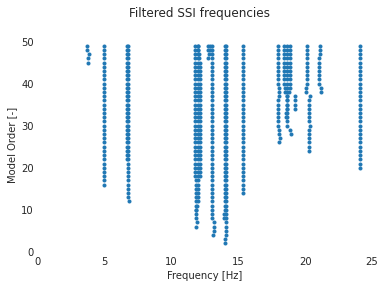

In [2]:
# SSI and subsequent filtering are applied:
freq, xi, Psi = ssi_cov_poles(data=data, fs=100, n_block_rows=100, max_model_order=50)

filtered_freq, filtered_xi, filtered_Psi = filter_ssi_poles(freq, xi, Psi)

with plt.style.context(
    [
        "seaborn-white",
        no_spines_dict,
        {"scatter.marker": "."},
    ]
):
    fig, ax = ssi_stability_plot(filtered_freq)
    fig.suptitle("Filtered SSI frequencies")

In [3]:
print("Length of filtered frequencies list: {}".format(len(filtered_freq)))
print("First item: {}".format(filtered_freq[0]))
print("Last item: {}".format(filtered_freq[-1]))


Length of filtered frequencies list: 49
First item: []
Last item: [39.11598645 37.41523608 34.83978749 26.44924049 24.10430983 21.14377434
  3.740894    4.98351543  6.79614765  6.69647488 20.12027011 18.85521746
 18.64805657 18.44649667 18.00042015 15.36661891 14.09540162 13.9927113
 11.80451713 12.02215198 11.96702142 13.06746907 12.7199777  12.86652345]


In [4]:
# Transform to ModalSets:
modal_sets = modal_sets_from_lists(filtered_freq, filtered_xi, filtered_Psi)
print("Length of filtered modal_sets list: {}".format(len(modal_sets)))
print("First item: {}".format(modal_sets[0]))
print("Last item: {}".format(modal_sets[-1]))

Length of filtered modal_sets list: 49
First item: ModalSet(n_modes = 0, modeshapes_array: (0, 18), frequencies=[])
Last item: ModalSet(n_modes = 24, modeshapes_array: (24, 18), frequencies=[39.11598645 37.41523608 34.83978749 26.44924049 24.10430983 21.14377434
  3.740894    4.98351543  6.79614765  6.69647488 20.12027011 18.85521746
 18.64805657 18.44649667 18.00042015 15.36661891 14.09540162 13.9927113
 11.80451713 12.02215198 11.96702142 13.06746907 12.7199777  12.86652345])


In [5]:
# An AllomerativeClusting object can be created from a Sequence of ModalSets:

clusters = modal_clusters(indexed_modal_sets_from_sequence(modal_sets))
print("Length of clusters: {}".format(len(clusters)))
print("First item: {}".format(clusters[0]))
print("Last item: {}".format(clusters[-1]))

Length of clusters: 17
First item: IndexedModalSet(n_modes = 118, modeshapes_array: (118, 18), indices=[ 5  6  7  8  9  9 10 10 11 11 12 12 13 13 14 14 15 15 16 16 17 17 17 18
 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23 24 24 24 25 25 25 26
 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 32 32 32 33 33 33 34
 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 39 39 40 40 40 41 41 41 42
 42 42 43 43 43 44 44 44 45 45 45 46 46 46 47 47 47 47 48 48 48 48], frequencies=[11.87546268 11.8887427  11.86742265 11.86980452 11.83151945 11.85543592
 11.87001181 11.89461496 12.02607667 11.87939388 12.02712508 11.8798384
 12.01662837 11.88056359 12.01664193 11.88060102 12.01616325 11.87849145
 12.0174314  11.879325   12.12658185 11.99916096 11.80323573 12.1263502
 11.999163   11.80321415 12.1262875  11.99918627 11.80316231 12.12620078
 11.9988649  11.80363706 12.12367602 11.99221201 11.80307077 12.12388171
 11.99234117 11.80314603 12.12347211 11.99224506 11.8031488  12.12342575
 11.99237429 11

In [6]:
for c in clusters:
    (
        mean_freq,
        mean_xi,
        mean_MAC,
        stdev_freq,
        stdev_xi,
        stdev_MAC,
    ) = single_set_statistics(c)
    print(
        f"{mean_freq:02.3f} +- {(stdev_freq/mean_freq):.3%} % Hz \t {mean_xi:.3f} +- {(stdev_xi/mean_xi):.3%} % damp. \t {mean_MAC:.3f} +- {stdev_MAC:.3f} MAC"
    )


11.973 +- 1.305% % Hz 	 0.023 +- 35.871% % damp. 	 0.572 +- 0.290 MAC
19.237 +- 5.796% % Hz 	 0.027 +- 57.824% % damp. 	 0.594 +- 0.320 MAC
18.675 +- 0.405% % Hz 	 0.021 +- 21.766% % damp. 	 0.870 +- 0.152 MAC
6.755 +- 0.580% % Hz 	 0.018 +- 19.761% % damp. 	 0.857 +- 0.131 MAC
14.091 +- 0.111% % Hz 	 0.024 +- 2.008% % damp. 	 0.967 +- 0.055 MAC
3.771 +- 0.835% % Hz 	 0.080 +- 18.632% % damp. 	 0.994 +- 0.006 MAC
13.076 +- 0.283% % Hz 	 0.023 +- 8.238% % damp. 	 0.986 +- 0.028 MAC
19.259 +- 0.054% % Hz 	 0.013 +- 7.916% % damp. 	 0.998 +- 0.002 MAC
38.536 +- 2.179% % Hz 	 0.018 +- 26.055% % damp. 	 0.959 +- 0.043 MAC
4.984 +- 0.044% % Hz 	 0.014 +- 3.563% % damp. 	 1.000 +- 0.001 MAC
34.682 +- 0.967% % Hz 	 0.022 +- 38.698% % damp. 	 0.990 +- 0.012 MAC
15.365 +- 0.011% % Hz 	 0.020 +- 0.463% % damp. 	 1.000 +- 0.000 MAC
13.990 +- 0.076% % Hz 	 0.024 +- 2.519% % damp. 	 0.997 +- 0.005 MAC
24.103 +- 0.024% % Hz 	 0.020 +- 0.662% % damp. 	 0.999 +- 0.001 MAC
12.873 +- 0.053% % Hz 	 0.022 

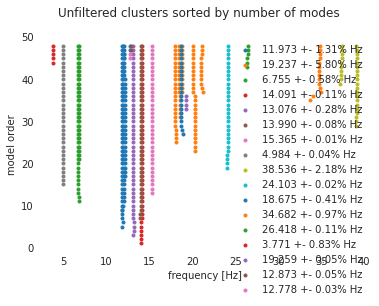

In [7]:
with plt.style.context(
    [
        "seaborn-white",
        no_spines_dict,
        {"scatter.marker": "."},
    ]
):
    fig, ax = plot_indexed_clusters(clusters, sort="num_modes", filter=False)
    ax.set(xlabel="frequency [Hz]", ylabel="model order")
    ax.legend()
    fig.suptitle("Unfiltered clusters sorted by number of modes")


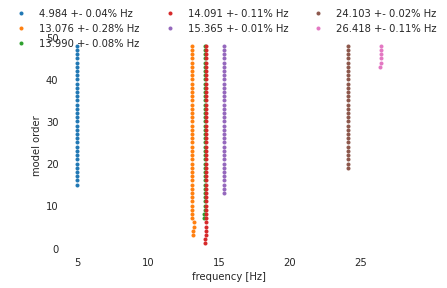

In [8]:
with plt.style.context(
    [
        "seaborn-white",
        no_spines_dict,
        {"scatter.marker": "."},
    ]
):
    fig, ax = plot_indexed_clusters(clusters, sort="freq", filter=True, max_freq_cov=0.005, min_n_modes=5)
    ax.set(xlabel="frequency [Hz]", ylabel="model order")
    fig.legend(loc="upper center", ncol=3)
    # fig.suptitle("Fltered clusters sorted by frequency")
